# Correlation between [CII] and the Spitzer 8 micron emission

Performed on the full FEEDBACK maps, no further down selection of sub regions is done in this Notebook.

When studying 8 micron: particularly focusing on PAH - [CII] link: heating-cooling.
- Question: How much can the 8 micron band be contaminated by other emission: line emission or continuum?

Still work on the background subtraction for the 8 micron emission
- Contamination of 8 micron band? Ask Xander + Where to find 8micron spectra for some if these regions (Spitzer/ISO)
- Idea to study possible role of self-absorption: typical luminosity? ask Slawa?

In [1]:
import numpy as np
import astropy.io.fits as pyfits
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import randint

In [2]:
#### User input ####

## information to fetch the necessary data
dir_path = "../data_FEEDBACK/" ## path to the data directory
name_CII = "_CII_final_res20_grid8_0p5_clean_integrated" ## identifier of the [CII] data file
name_8m = "_Spitzer_IRAC_8_20_8" ## identifier of the 8 micron data file

list_regions = [ ## list of the regions to be studied
    "CYGNUSX",
    "M16",
    "M17",
    "NGC7538",
    "RCW36",
    "RCW49",
    "RCW79",
    "RCW120",
    "W40",
    "ORIONA"
]

## Spitzer 8 micron bandwidth
bandwidth_8micron = 1.58e13 ## Hz
conv_OrionA = 2.9*4.8e-5*0.2021/10.4*0.74

## minimal intensity for the [CII] data
min_cut_CII = 20. 

## [CII] convert K km/s -> erg/s/cm2/sr
conv_CII = 7.0354e-6

## Maximum number of data points that will be randomly sampled to produce the kdeplot
num_points_kdeplot = 1e4

## plotting information
xlims = [-2.5,-0.3]
ylims = [-3.9, -2.2]

Performing the plotting for CYGNUSX
Performing the plotting for M16
Performing the plotting for M17
Performing the plotting for NGC7538
Performing the plotting for RCW36
Performing the plotting for RCW49
Performing the plotting for RCW79
Performing the plotting for RCW120
Performing the plotting for W40
Performing the plotting for ORIONA


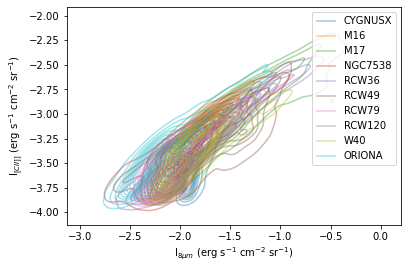

In [3]:
## Study the [CII] - 8 micron relation for different regions
data_list = [] ## to store the [CII] and 8 micron DataFrame for the different regions

for region in list_regions:
    print("Performing the plotting for {reg}".format(reg = region))
    
    ## get the [CII] data
    hdu = pyfits.open("{path}{region}/{region}{CII}.fits".format(path = dir_path, region = region, CII = name_CII))
    data_CII = hdu[0].data
    
    ## get the 8 micron data
    hdu = pyfits.open("{path}{region}/{region}{name}.fits".format(path = dir_path, region = region, name = name_8m))
    data_8m = hdu[0].data
    
    ## to 1D array
    data_CII = data_CII.ravel()
    data_8m = data_8m.ravel()
    
    ## remove data below [CII] intensity cut
    data_8m = data_8m[data_CII > min_cut_CII]
    data_CII = data_CII[data_CII > min_cut_CII]
    
    ## remove all nans from the data
    data_8m = data_8m[~np.isnan(data_CII)]
    data_CII = data_CII[~np.isnan(data_CII)]
    
    data_CII = data_CII[~np.isnan(data_8m)]
    data_8m = data_8m[~np.isnan(data_8m)]
    
    ## convert the 8 micron and [CII] data to erg/s/cm-2/sr
    if(region == "ORIONA"):
        data_8m = np.log10(data_8m * conv_OrionA)
    else:
        data_8m = np.log10(data_8m * bandwidth_8micron / 1e17)
    data_CII = np.log10(data_CII * conv_CII)
    
    ## generate a random number of indices for the data set
    if(len(data_CII) > num_points_kdeplot):
        rand_inds = randint(0, high = len(data_CII), size = int(num_points_kdeplot))
        data_CII = np.take(data_CII, rand_inds)
        data_8m = np.take(data_8m, rand_inds)
        
    ## create a DataFrame
    df = pd.DataFrame({"CII": data_CII, '8 micron': data_8m})
    
    ## store the data
    data_list.append(df)
    
    ## plot with kde plot
    g = sns.kdeplot(x = df["8 micron"], y = df["CII"], fill=False, alpha=0.4, label = region)

plt.ylabel('I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
plt.xlabel('I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


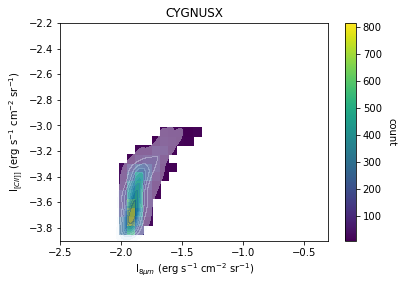

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


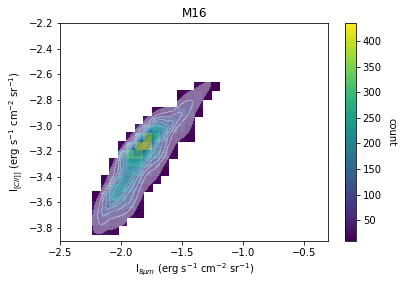

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


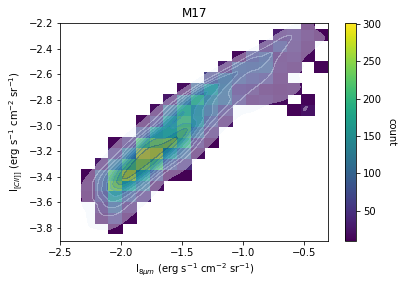

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


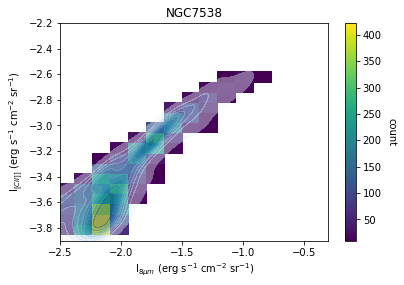

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


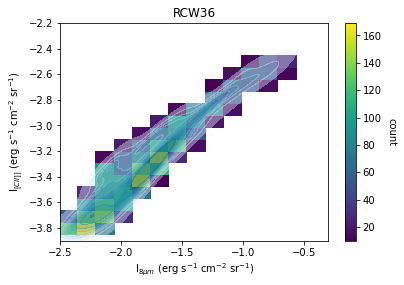

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


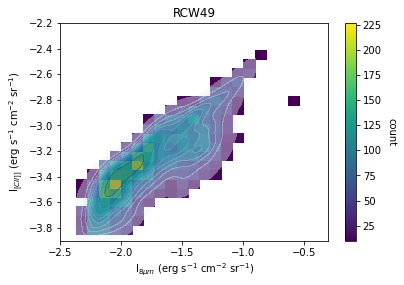

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


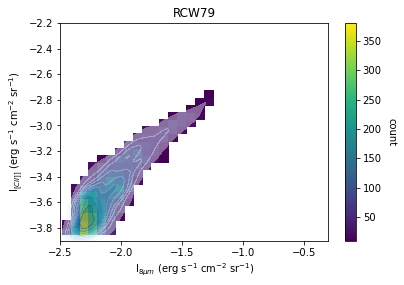

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


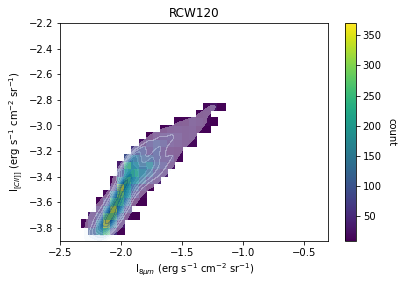

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


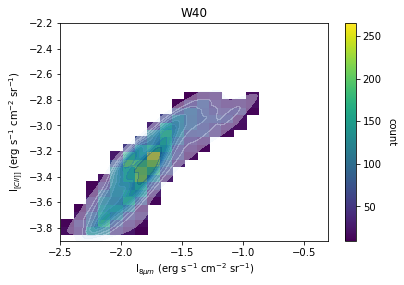

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


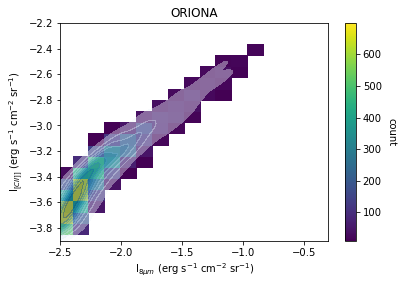

In [4]:
## plotting 2D histogram + seaborn for each region
for df, region in zip(data_list, list_regions):
    ## Add a title
    plt.title(region)
    
    ## plotting correlation 8 micron with the 2D histogram
    h = plt.hist2d(df["8 micron"], df["CII"], bins = int((len(df["CII"]))**0.33), cmin = 10)
    
    ## add a colorbar
    cbar = plt.colorbar()
    cbar.set_label("count", rotation = 270, labelpad = 15)

    ## plot kdeplot
    g = sns.kdeplot(df["8 micron"], df["CII"], fill=True, cmap='Blues', alpha=0.4)

    plt.ylabel('I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    plt.xlabel('I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    
    plt.xlim(xlims)
    plt.ylim(ylims)
    
    plt.show()

In [5]:
from scipy.optimize import curve_fit

In [6]:
#### functions ####

## linear fuction
def lin_func(x, a, b):
    return a*x + b


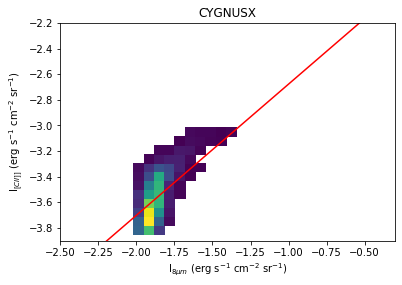

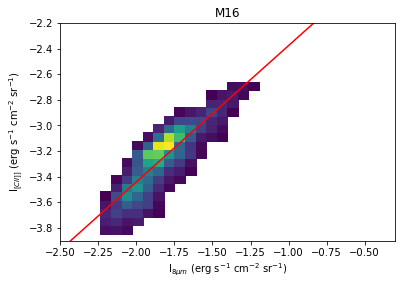

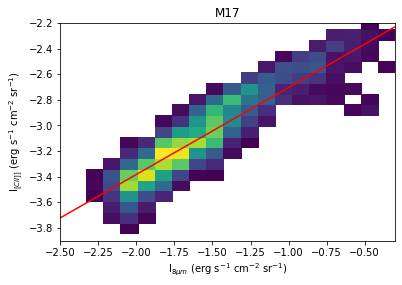

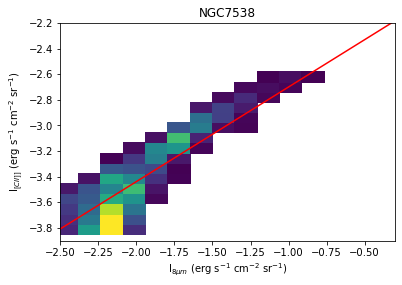

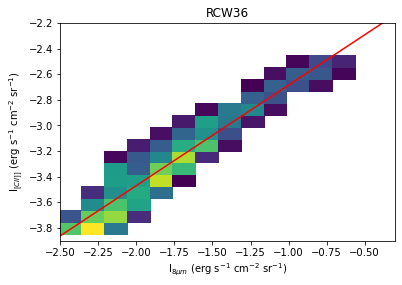

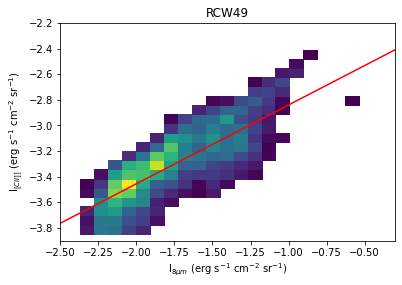

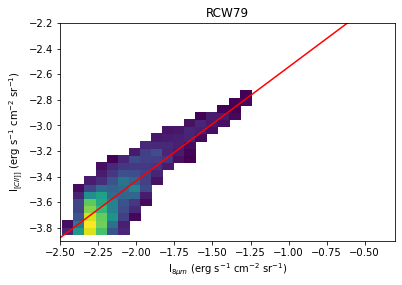

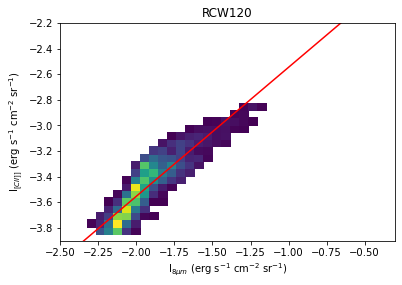

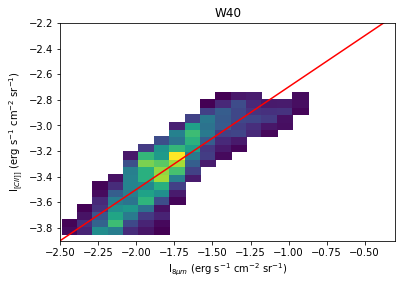

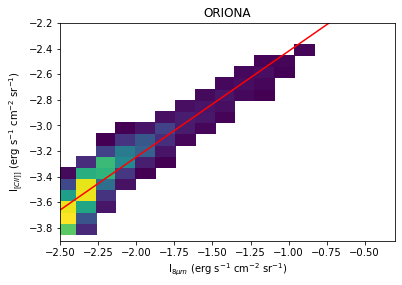

In [9]:
## fit the data with a powerlaw 
popt_list = []
for df, region in zip(data_list, list_regions):
    ## perform the fitting
    popt, pcov = curve_fit(lin_func, df["8 micron"], df["CII"])
    popt_list.append(popt)
    
    ## create information to plot the fitted curve
    x_points_fit = np.linspace(start = xlims[0], stop = xlims[1], num = 100)
    y_points_fit = lin_func(x_points_fit, popt[0], popt[1])
    
    ## plot the fitted curve on top of the 2D histograms ##
    # Add a title
    plt.title(region)
    
    ## plotting correlation 8 micron with the 2D histogram
    h = plt.hist2d(df["8 micron"], df["CII"], bins = int((len(df["CII"]))**0.33), cmin = 10)
    
    ## plot the fitted relation
    plt.plot(x_points_fit, y_points_fit, "r-")
    
    ## additional plot specifications
    plt.ylabel('I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    plt.xlabel('I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    
    plt.xlim(xlims)
    plt.ylim(ylims)
    
    plt.show()

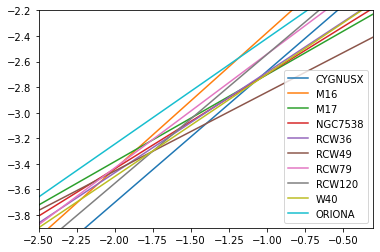

In [11]:
## plot to compare the different fitted relations
for popt, region in zip(popt_list, list_regions):
    ## create information to plot the fitted curve
    x_points_fit = np.linspace(start = xlims[0], stop = xlims[1], num = 100)
    y_points_fit = lin_func(x_points_fit, popt[0], popt[1])
    
    ## plot the fitted relation
    plt.plot(x_points_fit, y_points_fit, label = region)
    
    plt.xlim(xlims)
    plt.ylim(ylims)
    
    plt.legend()

plt.show()

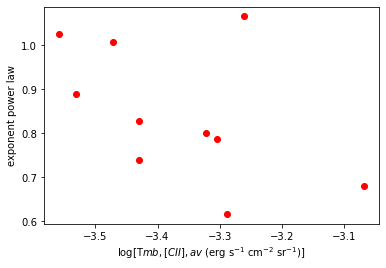

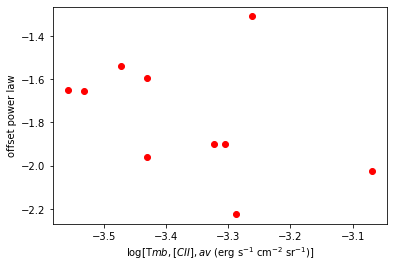

In [13]:
## investigate the link between the offset and powerlaw index as a function of average [CII] intensity
av_list = []
exp_list = []
offset_list = []
for popt, df in zip(popt_list, data_list):
    av_list.append(np.nanmean(df["CII"]))
    exp_list.append(popt[0])
    offset_list.append(popt[1])

## plot the results
plt.plot(av_list, exp_list, "ro")
plt.xlabel("log[T${mb, [CII], av}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]")
plt.ylabel("exponent power law")
plt.show()

## plot the results
plt.plot(av_list, offset_list, "ro")
plt.xlabel("log[T${mb, [CII], av}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]")
plt.ylabel("offset power law")
plt.show()
    

#### First conclusions
Regions with a lower intensity have a steeper power law: this indicates that the [CII]/ 8 micron relation flattens. What is the origin of this?
- Need to inspect presence of self-absorption

#### Inspecting the variance/scatter of the relation for each region

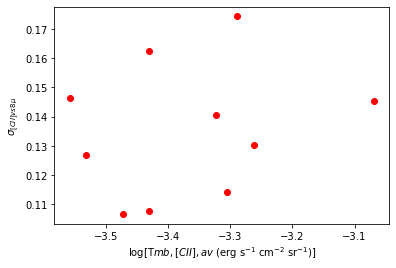

<ipython-input-24-dbf33528a236>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_regions, rotation = 45, ha="right")


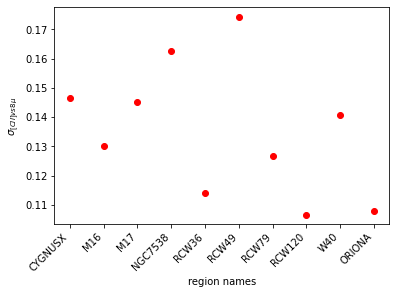

In [24]:
## calculating the standard deviation for each region
std_list = []
for df, popt in zip(data_list, popt_list):
    ## predict the [CII] intensity values for each 8 micron value based on the best fit
    pred_vals = lin_func(df["8 micron"], popt[0], popt[1])
    
    ## calculate the difference between the predicted and observed [CII] intensity
    diff_vals = df["CII"] - pred_vals
    
    ## calculate the typical standard deviation
    std_list.append(np.nanstd(diff_vals))
    
## plot the results as a function of the intensity
plt.plot(av_list, std_list, "ro")
plt.ylabel(r"$\sigma_{[CII] vs 8 \mu}$")
plt.xlabel("log[T${mb, [CII], av}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]")
plt.show()

## plot the results for each region name
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(list_regions, std_list, "ro")
ax.set_xticklabels(list_regions, rotation = 45, ha="right")
plt.ylabel(r"$\sigma_{[CII] vs 8 \mu}$")
plt.xlabel("region names")
plt.show()

In [ ]:
# STUDY SCATTER AS A FUNCTION OF THE BIN